In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmp1g9b41ql/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [3]:
import Foundation
import Just
import Path

In [4]:
public func FacesDataBunch(path: Path = mnistPath, bs: Int = 20)
   -> DataBunch<DataBatch<TF, TI>> {
    let tr_x = np.load((path/"trainX.npy").string).astype(np.float32) / 255.0
    let tr_y = np.load((path/"trainY.npy").string).astype(np.int32)
    let ts_x = np.load((path/"testX.npy").string).astype(np.float32) / 255.0
    let ts_y = np.load((path/"testY.npy").string).astype(np.int32)
    let xTrain = Tensor<Float>(ShapedArray<Float>(numpy: tr_x)!)
    let yTrain = Tensor<Int32>(ShapedArray<Int32>(numpy: tr_y)!)
    let xValid = Tensor<Float>(ShapedArray<Float>(numpy: ts_x)!)
    let yValid = Tensor<Int32>(ShapedArray<Int32>(numpy: ts_y)!)
    return DataBunch(train: Dataset(elements: DataBatch(xb:xTrain, yb: yTrain)), 
                     valid: Dataset(elements: DataBatch(xb:xValid, yb: yValid)),
                     trainLen: xTrain.shape[0],
                     validLen: xValid.shape[0],
                     bs: bs)
}


In [5]:
let d = FacesDataBunch(path: Path.home/"swift",bs: 40)

In [6]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [40, 10304]
  ▿ dimensions : 2 elements
    - 0 : 40
    - 1 : 10304


In [9]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid1: Int, nHid2: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid1, activation: relu)
        hidden2 = FADense(nHid1, nHid2, activation: relu)
        out =     FADense(nHid2, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [10]:
func modelInit() -> MyModel { return MyModel(nIn: 10304, nHid1: 2048,nHid2: 512, nOut: 20) }

In [11]:
public let FacesStats = (mean: TF(0.4617096), std: TF(0.20259255))

In [12]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [13]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [14]:
func optFunc(_ model: MyModel) -> SGD<MyModel> { return SGD(for: model, learningRate: 0.01)}

let learner = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_sgd = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [15]:
learner.fit(25)

Epoch 0: [1.8539932, 0.71875]                                              
Epoch 1: [1.2174962, 0.84375]                                             
Epoch 2: [0.88190305, 0.8875]                                             
Epoch 3: [0.6955739, 0.9125]                                              
Epoch 4: [0.6137949, 0.9125]                                              
Epoch 5: [0.5422925, 0.93125]                                             
Epoch 6: [0.4890307, 0.93125]                                             
Epoch 7: [0.4543429, 0.9375]                                              
Epoch 8: [0.43189716, 0.9375]                                             
Epoch 9: [0.40737504, 0.93125]                                            
Epoch 10: [0.39009762, 0.9375]                                            
Epoch 11: [0.37591353, 0.94375]                                           
Epoch 12: [0.36358482, 0.94375]                                           
Epoch 13: [0.35601577, 0

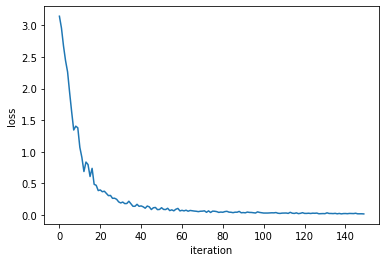

In [16]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [20]:
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}
let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [21]:
try! learner_nest.fit(25)

Epoch 0: [1.845933, 0.58125]                                              
Epoch 1: [1.1710975, 0.7875]                                              
Epoch 2: [0.9157022, 0.86875]                                             
Epoch 3: [0.6650981, 0.91875]                                             
Epoch 4: [0.5620896, 0.93125]                                             
Epoch 5: [0.49738646, 0.9375]                                             
Epoch 6: [0.45163232, 0.9375]                                             
Epoch 7: [0.4229123, 0.9375]                                              
Epoch 8: [0.39254785, 0.94375]                                            
Epoch 9: [0.37256137, 0.94375]                                            
Epoch 10: [0.3576217, 0.94375]                                            
Epoch 11: [0.34487, 0.94375]                                              
Epoch 12: [0.3319228, 0.94375]                                            
Epoch 13: [0.32004994, 0.

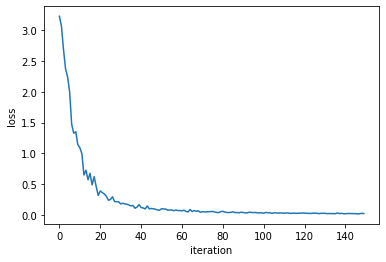

In [22]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [23]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [24]:
learner_nest_l1.fit(25)

Epoch 0: [1.7861443, 0.61875]                                             
Epoch 1: [1.1304924, 0.85625]                                             
Epoch 2: [0.8778175, 0.8625]                                              
Epoch 3: [0.6761229, 0.9]                                                 
Epoch 4: [0.57784194, 0.9125]                                             
Epoch 5: [0.5132065, 0.91875]                                             
Epoch 6: [0.46454722, 0.93125]                                            
Epoch 7: [0.42886433, 0.9375]                                             
Epoch 8: [0.40958452, 0.9375]                                             
Epoch 9: [0.38863173, 0.9375]                                             
Epoch 10: [0.36487895, 0.9375]                                            
Epoch 11: [0.35301787, 0.9375]                                            
Epoch 12: [0.34395805, 0.9375]                                            
Epoch 13: [0.33405334, 0.

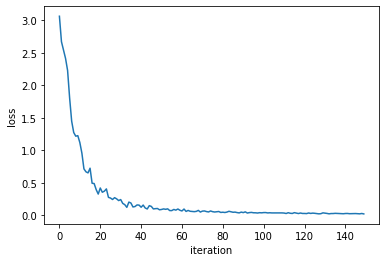

In [25]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [26]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [27]:
learner_nest_l2.fit(25)

Epoch 0: [1.0062835, 0.80625]                                               
Epoch 1: [0.55796367, 0.80625]                                              
Epoch 2: [0.2773656, 0.925]                                                 
Epoch 3: [0.2810804, 0.925]                                                 
Epoch 4: [0.23828597, 0.925]                                                
Epoch 5: [0.26346081, 0.91875]                                              
Epoch 6: [0.27271605, 0.9125]                                               
Epoch 7: [0.28130114, 0.925]                                                
Epoch 8: [0.28815252, 0.93125]                                              
Epoch 9: [0.28950414, 0.9375]                                              
Epoch 10: [0.2895252, 0.9375]                                              
Epoch 11: [0.28923967, 0.9375]                                             
Epoch 12: [0.28902355, 0.9375]                                              
Ep

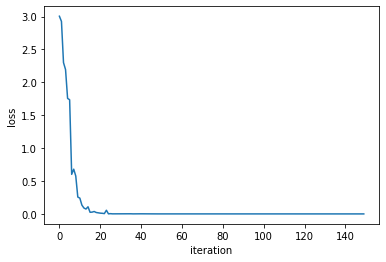

In [28]:
recorder_nest_l2.plotLosses()

In [30]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [177]:
func smooth_curve(points:Array<Float>, factor:Float=0.99) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

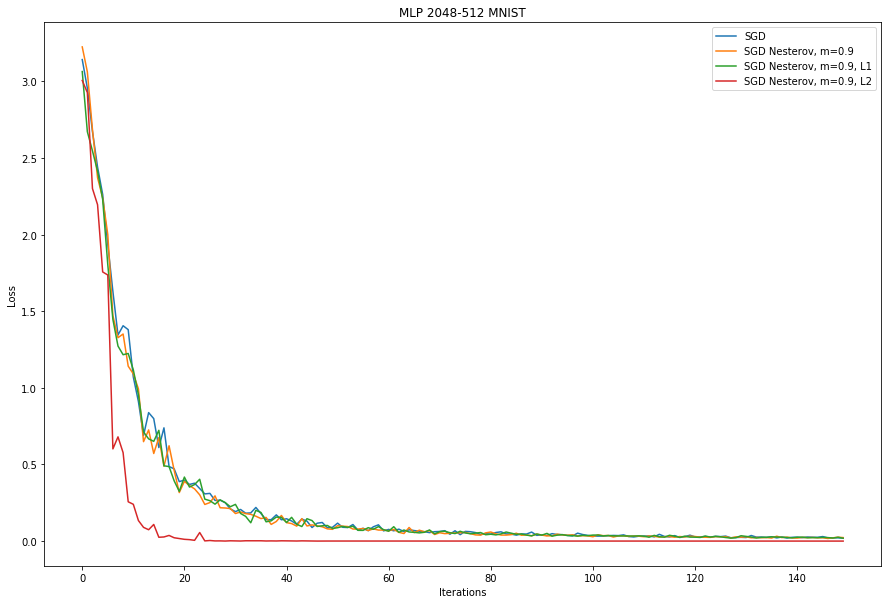

None


In [32]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 150
let y2 = Array(y[i..<n])
plt.plot(y2,Array(sgd[i..<n]), label:"SGD")
plt.plot(y2,Array(nest[i..<n]), label:"SGD Nesterov, m=0.9")
plt.plot(y2,Array(nest_l1[i..<n]), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,Array(nest_l2[i..<n]), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 2048-512 MNIST")
plt.show()